## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

In [2]:
using DelimitedFiles

Load some packages to make nice figures

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [4]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [28]:
Δtdyn = 0.05
Δtobs = 0.2

0.2

Define the time span of interest

In [29]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

500

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [30]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [31]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [32]:
### Process and observation noise
σx = 1e-10
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0])

In [33]:
ϵx.Σ

3×3 Diagonal{Float64,Array{Float64,1}}:
 1.0e-20   ⋅        ⋅ 
  ⋅       1.0e-20   ⋅ 
  ⋅        ⋅       1.0e-20

In [34]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [35]:
# Time span
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, zeros(Nx), tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 3-element Array{Float64,1}:
 0.0
 0.0
 0.0

Set initial condition of the true system

In [56]:
x0 = rand(model.π0);

In [57]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [58]:
# Ensemble size
Ne = 300

X0 = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X0, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×300 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
  0.656066  -0.0657601  -0.961142  …  -0.260673  -2.57414   -0.705379
 -0.874131   0.212965   -0.556089      0.744627   0.524036   0.876876
 -1.15442    0.418187   -0.40044       0.478027  -0.279812   0.0585067

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [59]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)

Stochastic EnKF  with filtered = false


In [60]:
Xenkf = seqassim(F, data, Tf, model.ϵx, enkf, deepcopy(X0), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [61]:
tspin = 50.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)

250

Time average root-mean-squared error 

In [62]:
rmse_enkf = mean(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), Tspin:Tf))

0.6398118270406539

Initialize the structure of the map

In [63]:
p = 1
# order = [[-1], [1; 1], [-1; 1; 0], [-1; 1; 1; 0]]
# order = [[-1], [p; p], [-1; p; 0], [-1; p; p; 0]]

order = [[-1], [-1; -1], [-1; -1; -1], [p; -1; -1 ;p], [-1; p; -1; p; p], [-1; -1; p; p; p; p]]

# parameters of the radial map
γ = 2.0
λ = 0.1
δ = 1e-8
κ = 10.0

dist = Float64.(metric_lorenz(3))
idx = vcat(collect(1:Ny)',collect(1:Ny)')

smf = SparseRadialSMF(x->x, ϵy, order, γ, λ, δ, κ, Ny, Nx, Ne, Δtdyn, Δtobs, dist, idx)

SparseRadialSMF(var"#21#22"(), AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0]), Sparse Radial Map of dimension Nx = 6 and order p = [[-1], [-1, -1], [-1, -1, -1], [1, -1, -1, 1], [-1, 1, -1, 1, 1], [-1, -1, 1, 1, 1, 1]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.1, 1.0e-8, 10.0)
, 3, 3, 0.05, 0.2, [0.0 1.0 1.0; 1.0 0.0 1.0; 1.0 1.0 0.0], [1 2 3; 1 2 3], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], false)

In [64]:
Xspin = vcat(zeros(Ny, Ne), deepcopy(Xenkf[Tspin+1]))

6×300 Array{Float64,2}:
  0.0       0.0       0.0       0.0      …   0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
 -3.10179  -4.39283  -3.23703  -3.74092     -3.76367  -3.45611  -3.38735
 -3.27257  -4.83607  -3.43135  -4.27753     -4.6194   -3.97881  -3.81562
 20.2613   21.3723   20.371    20.2632   …  19.5251   19.8877   20.0181

In [26]:
# Validation of the setup

Xspin = vcat(zeros(Ny, Ne), deepcopy(Xenkf[Tspin+1]))

ystar = data.yt[:,250]
data.tt[250]

ϵx(Xspin, Ny+1, Ny+Nx)

# Compute measurements
observe(F.h, Xspin, tspin, Ny, Nx)

# Perturbation of the measurements
smf.ϵy(Xspin, 1, Ny)
@show norm(Xspin)

# Optimize the map S
optimize(smf.S, Xspin; start = Ny+1)

norm(Xspin) = 1039.145636592384
xopt = [-0.0946863502205734, -0.44422492611388703, 0.2580895085188517, 0.8699918668265885, 2.490459234847318, 1.2295356565470779]
xopt = [-0.22605247424373912, -2.0410135040473203, -0.7973607910059543, -0.43972484385370625, 14.686342798345892, 0.7739444090835345, 1.8504324784495487, 1.2542410761237628]
xopt = [-0.02783496148168222, 0.27286971019499406, -10.943222118170938, 1.7718564560774581, 3.523937080899743, -3.3865336108066533, 110.03704650635659, 2.927925146414227, 8.68617564329611, 3.6915450232026497]


In [ ]:
# Evaluate the transport map
Sx = evaluate(smf.S, Xspin; start = Ny+1)

Xpost = deepcopy(Xspin)
inverse!(Xpost, deepcopy(Sx), smf.S, ystar; start = Ny+1)

@show norm(Xpost[1:Ny,:] .- ystar)

@show norm(evaluate(smf.S, Xspin; start = Ny+1)-evaluate(smf.S, Xpost; start = Ny+1))

In [65]:
tsmf = 100.0
Tsmf = ceil(Int64, (tsmf-tspin)/Δtobs)

250

In [66]:
Xsmf = seqassim(F, data, Tsmf, model.ϵx, smf, Xspin, model.Ny, model.Nx, tspin);

Progress:  36%|██████████████▋                          |  ETA: 0:00:01┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:345
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:351
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:345
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:345
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interface.jl:351
Progress:  40%|████████████████▍                        |  ETA: 0:00:04┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/9EjAY/src/integrator_interfac

LoadError: [91mArgumentError: The interval [a,b] is not a bracketing interval.[39m
[91mYou need f(a) and f(b) to have different signs (f(a) * f(b) < 0).[39m
[91mConsider a different bracket or try fzero(f, c) with an initial guess c.[39m



In [24]:
Xsmf

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [25]:
rmse_smf = mean(map(i->norm(data.xt[:,Tspin+i]-mean(Xsmf[i+1]; dims = 2))/sqrt(Nx), 1:Tsmf))

LoadError: [91mUndefVarError: Xsmf not defined[39m

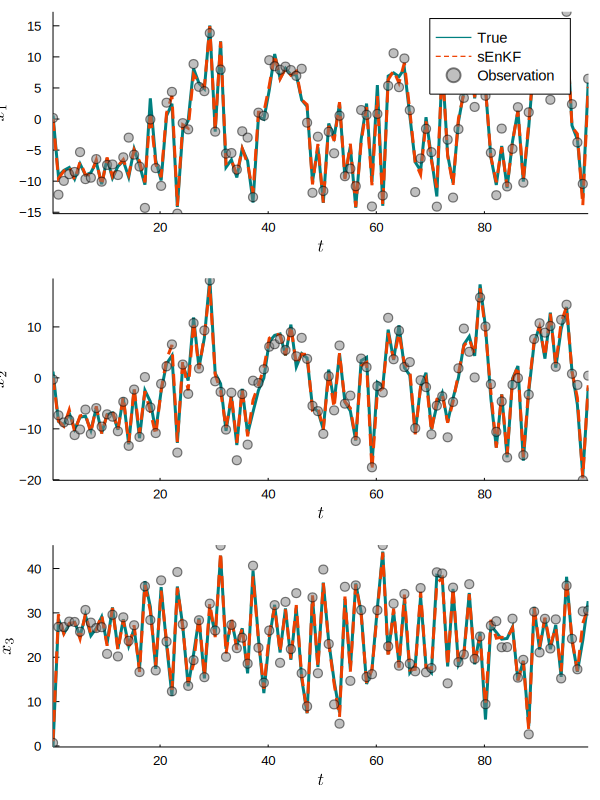

In [26]:
nb = 1
ne = Tf
Δ = 5
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)),
         legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xenkf)[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

In [27]:
nb = 1
ne = Tspin+Tsmf
Δ = 5
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xenkf[1:Tspin+1], Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
    vline!(plt[i,1], [tspin], color = :grey2, linestyle = :dash, label = "")
end

plt

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [28]:
@time optimize(smf.S, X0; start = Ny+1)

  5.054692 seconds (15.42 M allocations: 733.770 MiB, 3.65% gc time)


In [29]:
X0 = vcat(zeros(Ny, Ne), deepcopy(Xenkf[Tspin+1]))

# Add process noise
model.ϵx(X0, Ny+1, Ny+Nx)

# Generate the observations
observe(h, X0, tspin, Ny, Nx)

# Apply the observation noise
ϵy(X0, 1, Ny)

In [30]:
smf.S[3]

3-th component of a Sparse KR rearrangement of order p = [-1, -1, -1]


In [31]:
X0

6×300 Array{Float64,2}:
  -3.97186   -8.88353   -7.35813  …   -8.66906   -3.4362   -11.023
  -8.94689   -9.89351  -10.11         -7.63734  -10.5471    -8.53389
  17.7141    17.5468    16.9652       17.7838    16.5009    17.5757
  -6.16907   -7.3501    -7.29347      -6.78451   -6.43223   -7.44183
 -10.1047   -11.8445   -11.6923      -11.1935   -10.3871   -11.9424
  15.5994    16.9444    16.9342   …   15.8297    16.281     17.2098

In [32]:
@time F = evaluate(smf.S, X0; start = Ny+1)

  0.117456 seconds (336.05 k allocations: 16.501 MiB)


6×300 Array{Float64,2}:
   0.0    0.0    0.0    0.0    0.0  …    0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    NaN
 NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    NaN
 NaN    NaN    NaN    NaN    NaN    …  NaN    NaN    NaN    NaN    NaN

In [33]:
F0 = deepcopy(F)

6×300 Array{Float64,2}:
   0.0    0.0    0.0    0.0    0.0  …    0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    NaN
 NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN    NaN    NaN
 NaN    NaN    NaN    NaN    NaN    …  NaN    NaN    NaN    NaN    NaN

In [34]:
ystar = data.yt[:,Tspin] 

3-element Array{Float64,1}:
  -7.370604991114067
 -11.707565951836228
  17.05299261342628

In [35]:
Xpost = deepcopy(X0)

6×300 Array{Float64,2}:
  -3.97186   -8.88353   -7.35813  …   -8.66906   -3.4362   -11.023
  -8.94689   -9.89351  -10.11         -7.63734  -10.5471    -8.53389
  17.7141    17.5468    16.9652       17.7838    16.5009    17.5757
  -6.16907   -7.3501    -7.29347      -6.78451   -6.43223   -7.44183
 -10.1047   -11.8445   -11.6923      -11.1935   -10.3871   -11.9424
  15.5994    16.9444    16.9342   …   15.8297    16.281     17.2098

In [36]:
inverse!(Xpost, F, smf.S, ystar)

LoadError: [91mArgumentError: The interval [a,b] is not a bracketing interval.[39m
[91mYou need f(a) and f(b) to have different signs (f(a) * f(b) < 0).[39m
[91mConsider a different bracket or try fzero(f, c) with an initial guess c.[39m



In [37]:
Xpost

6×300 Array{Float64,2}:
  -7.3706    -7.3706   -7.3706   …   -7.3706    -7.3706    -7.3706
 -11.7076   -11.7076  -11.7076      -11.7076   -11.7076   -11.7076
  17.053     17.053    17.053        17.053     17.053     17.053
  -6.16907   -7.3501   -7.29347      -6.78451   -6.43223   -7.44183
 -10.1047   -11.8445  -11.6923      -11.1935   -10.3871   -11.9424
  15.5994    16.9444   16.9342   …   15.8297    16.281     17.2098

In [38]:
norm(evaluate(smf.S, Xpost; start = Ny+1)-F)/norm(F)

NaN

In [39]:
smf.S

Sparse Radial Map of dimension Nx = 6 and order p = [[-1], [-1, -1], [-1, -1, -1], [1, -1, -1, 1], [-1, 1, -1, 1, 1], [-1, -1, 1, 1, 1, 1]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.1, 1.0e-8, 10.0)


In [40]:
Xsmf = seqassim(F, data, Tsmf, model.ϵx, smf, Xspin, model.Ny, model.Nx, tspin);

LoadError: [91mUndefVarError: Xspin not defined[39m

In [41]:
(rmse_enkf - rmse_smf)/rmse_enkf

LoadError: [91mUndefVarError: rmse_smf not defined[39m

In [42]:
mean_hist(vcat(Xenkf[1:Tspin], Xsmf[2:end]))

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [43]:
X = vcat(zeros(Ny, Ne), Xspin[end])

LoadError: [91mUndefVarError: Xspin not defined[39m

In [44]:
prob = ODEProblem(F.f, zeros(Nx), (tspin, tspin + Δtobs))

LoadError: [91mtype Array has no field f[39m

In [45]:
prob_func(prob,i,repeat) = ODEProblem(prob.f, X[Ny+1:Ny+Nx,i],prob.tspan)

ensemble_prob = EnsembleProblem(prob,output_func = (sol,i) -> (sol[end], false),
prob_func=prob_func)
sim = solve(ensemble_prob, Tsit5(), EnsembleThreads(),trajectories = Ne,
            dense = false, save_everystep=false);

@inbounds for i=1:Ne
    X[Ny+1:Ny+Nx, i] .= deepcopy(sim[i])
end

LoadError: [91mUndefVarError: X not defined[39m

In [353]:
X

6×500 Array{Float64,2}:
  0.0       0.0       0.0       0.0      …   0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  8.0287    7.80903   8.07157   8.77422      8.35386   8.4506    8.3785
  1.66881   1.75556   1.85259   2.38881      1.93731   2.21379   2.29732
 32.9223   32.8453   33.0323   33.8473   …  33.6527   33.5966   33.1985

In [354]:
J = 1
n0 = ceil(Int64, tspin/Δtobs) + 1
Acycle = n0:n0+J-1
i=1

ystar = data.yt[:,Acycle[i]]

3-element Array{Float64,1}:
  8.306885381021859
  2.7831761780044895
 32.394077428832475

In [355]:
data.tt[201]

10.05

In [356]:
data.yt[:,201]

3-element Array{Float64,1}:
  8.306885381021859
  2.7831761780044895
 32.394077428832475

In [357]:
ϵx(X, Ny+1, Ny+Nx)

In [358]:
X

6×500 Array{Float64,2}:
  0.0       0.0       0.0       0.0      …   0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  8.03895   7.69291   8.1778    8.8717       8.23649   8.57034   8.42855
  1.66038   1.85278   1.77955   2.34759      2.08591   2.17082   2.28977
 32.9719   33.0358   32.8052   33.9504   …  33.8086   33.5683   33.0337

In [359]:
observe(F.h, X, tspin+1*Δtobs, Ny, Nx)

In [360]:
X

6×500 Array{Float64,2}:
  8.03895   7.69291   8.1778    8.8717   …   8.23649   8.57034   8.42855
  1.66038   1.85278   1.77955   2.34759      2.08591   2.17082   2.28977
 32.9719   33.0358   32.8052   33.9504      33.8086   33.5683   33.0337
  8.03895   7.69291   8.1778    8.8717       8.23649   8.57034   8.42855
  1.66038   1.85278   1.77955   2.34759      2.08591   2.17082   2.28977
 32.9719   33.0358   32.8052   33.9504   …  33.8086   33.5683   33.0337

In [361]:
# Perturbation of the measurements
ϵy(X, 1, Ny)

In [362]:
X

6×500 Array{Float64,2}:
  8.44231   6.3435    8.63596  10.1562   …   7.93684   7.23888   8.55869
  1.4125    2.85397   1.09649   1.28893      1.51041   2.87658   0.696525
 33.098    33.2989   33.3297   35.1126      34.8881   34.381    31.7023
  8.03895   7.69291   8.1778    8.8717       8.23649   8.57034   8.42855
  1.66038   1.85278   1.77955   2.34759      2.08591   2.17082   2.28977
 32.9719   33.0358   32.8052   33.9504   …  33.8086   33.5683   33.0337

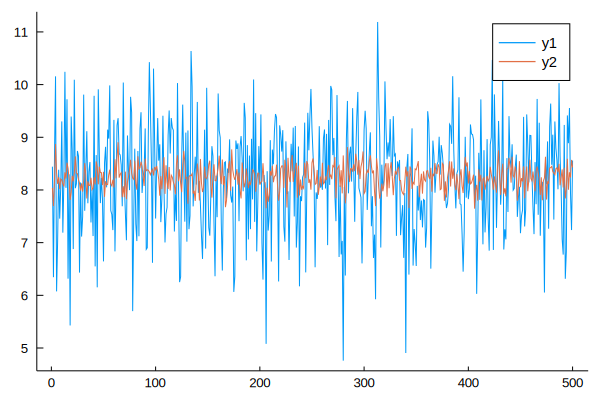

In [363]:
plot(X[1,:])
plot!(X[4,:])

In [364]:
M = totalordermap(X, 1; b = "CstLinProHermite")

Hermite map of dimension 6:
Map component of dimension 1 with Nψ = 1 active features
Map component of dimension 2 with Nψ = 2 active features
Map component of dimension 3 with Nψ = 3 active features
Map component of dimension 4 with Nψ = 4 active features
Map component of dimension 5 with Nψ = 5 active features
Map component of dimension 6 with Nψ = 6 active features


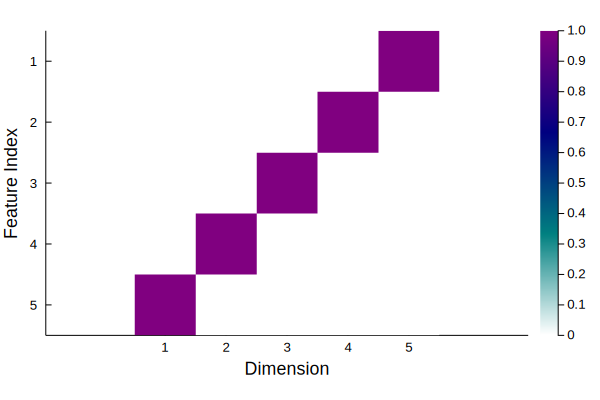

In [365]:
plot(M[5].I.f)

In [366]:
std.(eachslice(X; dims = 1))

6-element Array{Float64,1}:
 1.0200709137013684
 1.0264850033422663
 0.9974689992351282
 0.2299157799165
 0.32686194241196814
 0.29444014165777616

In [367]:
optimize(M, X, nothing; withqr = true, apply_rescaling = true,
	     verbose = true, start = Ny+1, P = serial, hessprecond = true)

error = 1.3546239880381277
error = 1.2221203538239531
error = 1.0843219147594658


Hermite map of dimension 6:
Map component of dimension 1 with Nψ = 1 active features
Map component of dimension 2 with Nψ = 2 active features
Map component of dimension 3 with Nψ = 3 active features
Map component of dimension 4 with Nψ = 4 active features
Map component of dimension 5 with Nψ = 5 active features
Map component of dimension 6 with Nψ = 6 active features


In [368]:
# M[6].I.f.coeff .= [1.0; 0.0; 0.0; 0.0; 0.0; 0.0]

In [369]:
getcoeff(M[6])

6-element Array{Float64,1}:
  0.7086460177422597
  0.5801048756301482
 -1.0417044486373217
 -0.2679667613389012
  0.10555362722697936
  0.026053703893004702

In [370]:
evaluate(M, X[:,1:1]; apply_rescaling = true)[6,1]

-1.2127254438573902

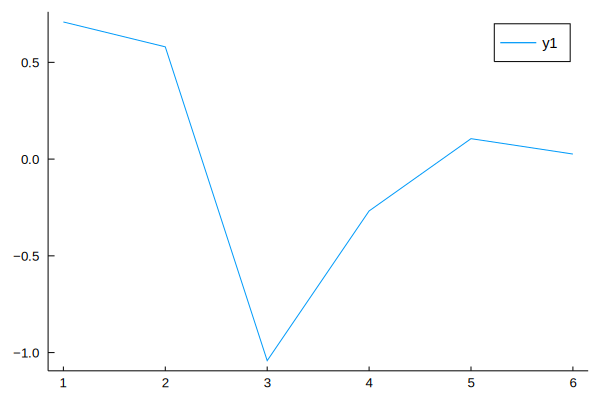

In [371]:
plot(getcoeff(M[6]))

In [372]:
X

6×500 Array{Float64,2}:
  8.44231   6.3435    8.63596  10.1562   …   7.93684   7.23888   8.55869
  1.4125    2.85397   1.09649   1.28893      1.51041   2.87658   0.696525
 33.098    33.2989   33.3297   35.1126      34.8881   34.381    31.7023
  8.03895   7.69291   8.1778    8.8717       8.23649   8.57034   8.42855
  1.66038   1.85278   1.77955   2.34759      2.08591   2.17082   2.28977
 32.9719   33.0358   32.8052   33.9504   …  33.8086   33.5683   33.0337

In [373]:
Mxpush = deepcopy(evaluate(M, X; apply_rescaling = true, start = Ny+1, P = serial))

6×500 Array{Float64,2}:
  0.0        0.0        0.0       …   0.0         0.0        0.0
  0.0        0.0        0.0           0.0         0.0        0.0
  0.0        0.0        0.0           0.0         0.0        0.0
 -0.816132  -2.33472   -0.175414     -0.0715097   1.39229    1.32251
 -0.570628   0.604989  -0.361137      0.655584   -0.305088   0.873459
 -1.21273    1.04068   -2.51129   …   2.1348     -0.108816  -1.26328

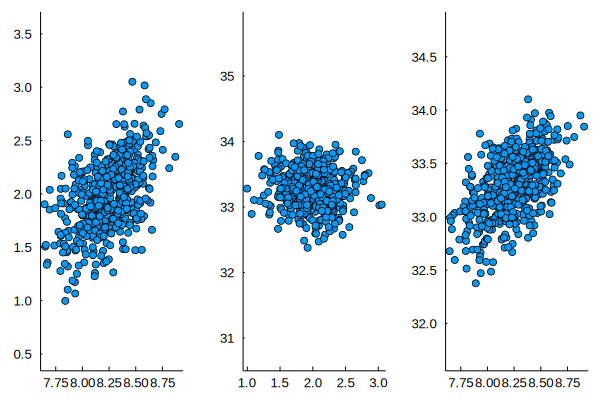

In [374]:
plt = plot(layout = grid(1,3), legend = false)
    scatter!(plt[1,1], X[4,:], X[5,:], ratio = 1)
    scatter!(plt[1,2], X[5,:], X[6,:], ratio = 1)
    scatter!(plt[1,3], X[4,:], X[6,:], ratio = 1)
plt

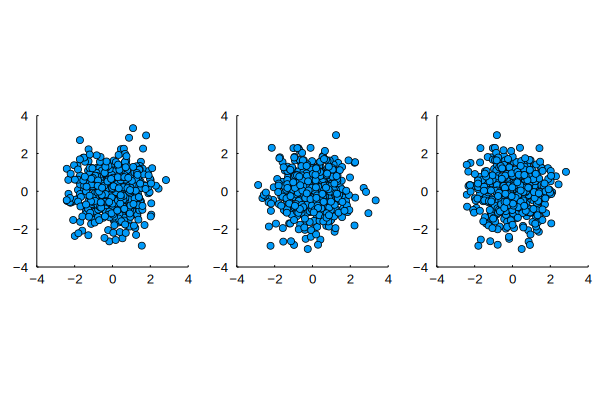

In [375]:
plt = plot(layout = grid(1,3), xlim = (-4, 4), ylim = (-4,4), legend = false)
    scatter!(plt[1,1], Mxpush[4,:], Mxpush[5,:], ratio = 1)
    scatter!(plt[1,2], Mxpush[5,:], Mxpush[6,:], ratio = 1)
    scatter!(plt[1,3], Mxpush[4,:], Mxpush[6,:], ratio = 1)
plt

In [383]:
# ystar .-= view(M.L.μ,1:Ny)
# ystar ./= M.L.L.diag[1:Ny]

In [385]:
ystar = data.yt[:,201] 

3-element Array{Float64,1}:
  8.306885381021859
  2.7831761780044895
 32.394077428832475

In [386]:
Xpost = deepcopy(X)

6×500 Array{Float64,2}:
  8.44231   6.3435    8.63596  10.1562   …   7.93684   7.23888   8.55869
  1.4125    2.85397   1.09649   1.28893      1.51041   2.87658   0.696525
 33.098    33.2989   33.3297   35.1126      34.8881   34.381    31.7023
  8.03895   7.69291   8.1778    8.8717       8.23649   8.57034   8.42855
  1.66038   1.85278   1.77955   2.34759      2.08591   2.17082   2.28977
 32.9719   33.0358   32.8052   33.9504   …  33.8086   33.5683   33.0337

In [387]:
hybridinverse!(Xpost, copy(Mxpush), M, ystar; start = Ny+1, P = serial, apply_rescaling = true)

6×500 Array{Float64,2}:
  8.30689   8.30689   8.30689   8.30689  …   8.30689   8.30689   8.30689
  2.78318   2.78318   2.78318   2.78318      2.78318   2.78318   2.78318
 32.3941   32.3941   32.3941   32.3941      32.3941   32.3941   32.3941
  8.07636   7.74896   8.21449   8.77727      8.23689   8.55248   8.53743
  1.80824   1.9039    1.95728   2.47009      2.24528   2.19939   2.50568
 32.8835   33.01     32.686    33.6381   …  33.5787   33.4244   33.0522

In [388]:
data.xt[:,201]

3-element Array{Float64,1}:
  8.435589773305827
  2.0968910267841268
 33.06847290332517

In [389]:
evaluate(M, X; apply_rescaling = true, start = Ny+1, P = serial)

6×500 Array{Float64,2}:
  0.0        0.0        0.0       …   0.0         0.0        0.0
  0.0        0.0        0.0           0.0         0.0        0.0
  0.0        0.0        0.0           0.0         0.0        0.0
 -0.816132  -2.33472   -0.175414     -0.0715097   1.39229    1.32251
 -0.570628   0.604989  -0.361137      0.655584   -0.305088   0.873459
 -1.21273    1.04068   -2.51129   …   2.1348     -0.108816  -1.26328

In [390]:
evaluate(M, vcat(repeat(data.yt[:,201], 1, Ne), Xpost[Ny+1:Ny+Nx,:]); apply_rescaling = true, start = Ny+1, P = serial)

6×500 Array{Float64,2}:
  0.0        0.0        0.0       …   0.0         0.0        0.0
  0.0        0.0        0.0           0.0         0.0        0.0
  0.0        0.0        0.0           0.0         0.0        0.0
 -0.816132  -2.33472   -0.175414     -0.0715097   1.39229    1.32251
 -0.570628   0.604989  -0.361137      0.655584   -0.305088   0.873459
 -1.21273    1.04068   -2.51129   …   2.1348     -0.108816  -1.26328

In [391]:
evaluate(M, vcat(repeat(ystar, 1, Ne), Xpost[Ny+1:Ny+Nx,:]); apply_rescaling = true, start = Ny+1, P = serial)

6×500 Array{Float64,2}:
  0.0        0.0        0.0       …   0.0         0.0        0.0
  0.0        0.0        0.0           0.0         0.0        0.0
  0.0        0.0        0.0           0.0         0.0        0.0
 -0.816132  -2.33472   -0.175414     -0.0715097   1.39229    1.32251
 -0.570628   0.604989  -0.361137      0.655584   -0.305088   0.873459
 -1.21273    1.04068   -2.51129   …   2.1348     -0.108816  -1.26328

In [392]:
norm(evaluate(M, X; apply_rescaling = true, start = Ny+1, P = serial) - evaluate(M, vcat(repeat(ystar, 1, Ne), Xpost[Ny+1:Ny+Nx,:]); apply_rescaling = true, start = Ny+1, P = serial))/norm(evaluate(M, X; apply_rescaling = true, start = Ny+1, P = serial))

5.855089439431769e-15

In [397]:
norm(evaluate(M, X; apply_rescaling = true, start = Ny+1, P = serial) - evaluate(M, vcat(repeat(data.yt[:,201], 1, Ne), Xpost[Ny+1:Ny+Nx,:]); apply_rescaling = true, start = Ny+1, P = serial))/norm(evaluate(M, X; apply_rescaling = true, start = Ny+1, P = serial))

5.855089439431769e-15

In [398]:
Xpost

6×500 Array{Float64,2}:
  8.30689   8.30689   8.30689   8.30689  …   8.30689   8.30689   8.30689
  2.78318   2.78318   2.78318   2.78318      2.78318   2.78318   2.78318
 32.3941   32.3941   32.3941   32.3941      32.3941   32.3941   32.3941
  8.07636   7.74896   8.21449   8.77727      8.23689   8.55248   8.53743
  1.80824   1.9039    1.95728   2.47009      2.24528   2.19939   2.50568
 32.8835   33.01     32.686    33.6381   …  33.5787   33.4244   33.0522

In [399]:
mean(Xpost; dims = 2)

6×1 Array{Float64,2}:
  8.306885381021859
  2.7831761780044753
 32.39407742883269
  8.252309536965596
  2.079636350585093
 33.205527730327915

In [400]:
data.xt[:,201]

3-element Array{Float64,1}:
  8.435589773305827
  2.0968910267841268
 33.06847290332517

In [396]:
norm(mean(Xpost[4:end,:]; dims = 2)-data.xt[:,201])/sqrt(Nx)

0.13250584199500554

Define the stochastic map filter `smf`, based on the `HermiteMap` `S`. 

In [103]:
X0 = vcat(zeros(Ny, Ne), Xspin[end])

# Add process noise
model.ϵx(X0, Ny+1, Ny+Nx)

# Generate the observations
observe(h, X0, tspin, Ny, Nx)

# Apply the observation noise
ϵy(X0, 1, Ny)

In [192]:
# m = 40
# S = HermiteMap(m, X0; diag = true, b = "CstLinProHermite")

S = totalordermap(X0, 2; b = "CstProHermite")

LoadError: [91mUndefVarError: X0 not defined[39m

In [193]:
# @time optimize(S, X0, "kfolds"; withqr = true, verbose = true, hessprecond = true, start = Ny+1)
@time optimize(S, X0, nothing; withqr = true, verbose = true, hessprecond = true, start = Ny+1)

LoadError: [91mUndefVarError: S not defined[39m

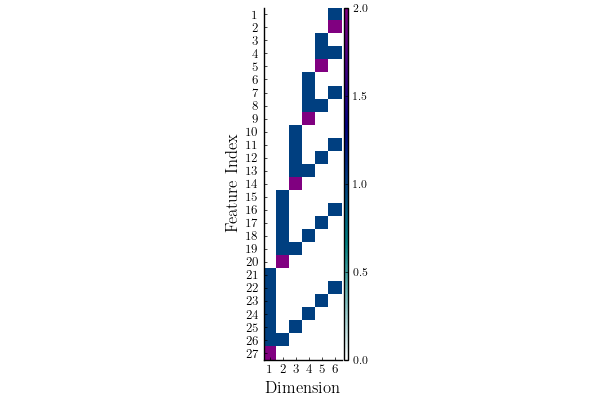

In [127]:
plot(S[6].I.f)

In [191]:
smf = FixedOrderStochMapFilter(x->x, ϵy, S, Ny, Nx, Δtdyn, Δtobs, false)

LoadError: [91mUndefVarError: S not defined[39m

In [129]:
mean(evaluate(S, X0; start = Ny+1); dims = 2)

6×1 Matrix{Float64}:
  0.0
  0.0
  0.0
 -0.00048330225574446994
 -0.004491294934531196
 -0.002129227728331044

In [130]:
cov(evaluate(S, X0; start = Ny+1); dims = 2)

6×6 Matrix{Float64}:
 0.0  0.0  0.0   0.0           0.0          0.0
 0.0  0.0  0.0   0.0           0.0          0.0
 0.0  0.0  0.0   0.0           0.0          0.0
 0.0  0.0  0.0   1.00199      -0.00020889  -0.000105526
 0.0  0.0  0.0  -0.00020889    1.00196      5.97084e-6
 0.0  0.0  0.0  -0.000105526   5.97084e-6   1.00174

In [131]:
Sxpush = evaluate(S, X0; start = Ny+1)[Ny+1:end,:]

3×500 Matrix{Float64}:
 -0.791481   0.122902  -0.251349  …  -1.6784     -0.771095   -0.764755
  0.60731   -1.0725     1.55565       1.30211     0.691928   -0.0538081
  0.799985  -0.247175   0.510229     -0.0322669  -0.0151946   1.99358

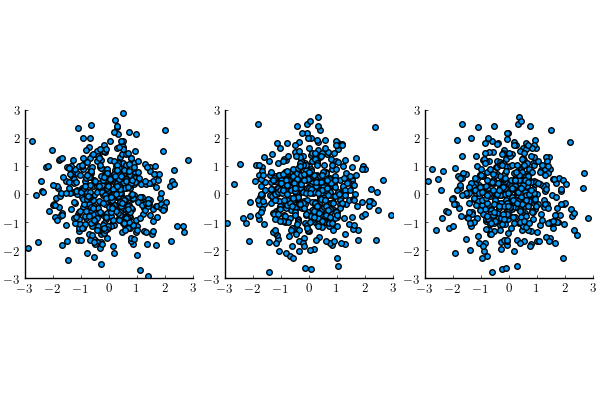

In [132]:
plt = plot(layout = grid(1,3), xlim = (-3, 3), ylim = (-3,3), legend = false)
    scatter!(plt[1,1], Sxpush[1,:], Sxpush[2,:], ratio = 1)
    scatter!(plt[1,2], Sxpush[2,:], Sxpush[3,:], ratio = 1)
    scatter!(plt[1,3], Sxpush[1,:], Sxpush[3,:], ratio = 1)
plt

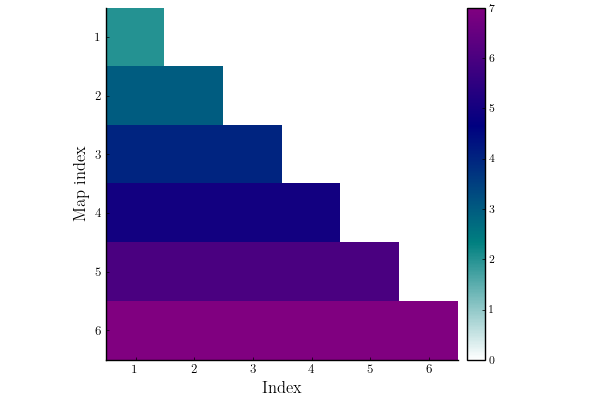

In [133]:
plot(S)

In [135]:
smf.M[6].I.f.B

MultiBasis(Basis of 5 functions: Constant, Linear, 0th -> 2th degree Probabilistic Hermite function
, 6)